# MVA2018/2019 - Deep Learning - Mini-project1

#### Author: ZHANG Cheng
#### Email: cheng.zhang@polytechnique.edu

## Getting started
We first define useful functions for generating training and testing data.

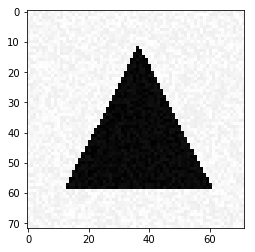

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## Simple Classification

In [2]:
# generate fixed location training dataset of 300 samples
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Define a linear classifier (a simple neural network with only input and output layers), use 'softmax' for output layer, use SGD optimizer with a learning rate 0.001.

Train over 20 epochs with batch size of 32.

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras import utils as np_utils

model = Sequential()
model.add(Dense(3, input_dim = IMAGE_SIZE**2))
model.add(Activation('softmax'))

sgd = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, np_utils.to_categorical(Y_train, 3), epochs = 20, batch_size = 32)

Using TensorFlow backend.


Epoch 1/20
300/300 [==============================] - 0s 552us/step - loss: 1.0805 - acc: 0.4433
Epoch 2/20
300/300 [==============================] - 0s 136us/step - loss: 0.9534 - acc: 0.5600
Epoch 3/20
300/300 [==============================] - 0s 163us/step - loss: 0.8434 - acc: 0.6533
Epoch 4/20
300/300 [==============================] - 0s 160us/step - loss: 0.8112 - acc: 0.7100
Epoch 5/20
300/300 [==============================] - 0s 152us/step - loss: 0.7541 - acc: 0.6900
Epoch 6/20
300/300 [==============================] - 0s 133us/step - loss: 0.7124 - acc: 0.7200
Epoch 7/20
300/300 [==============================] - 0s 130us/step - loss: 0.6875 - acc: 0.7433
Epoch 8/20
300/300 [==============================] - 0s 138us/step - loss: 0.6676 - acc: 0.7267
Epoch 9/20
300/300 [==============================] - 0s 153us/step - loss: 0.6306 - acc: 0.7700
Epoch 10/20
300/300 [==============================] - 0s 156us/step - loss: 0.6068 - acc: 0.7567
Epoch 11/20
300/300 [========

We see that the final accuracy is around 87% (This accuracy may change with each training, it is around 80% in general). Then we try some samples to see the predictions.

In [5]:
# generate a disk
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [6]:
# generate a triangle
X_test, _ = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

In [7]:
# generate a rectangle
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1.0000000e+00, 2.2006785e-21, 0.0000000e+00]], dtype=float32)

We can see that the model can predict well different shapes.

Now we try to use Adam optimizer with the same learning rate 0.001. We still train 20 epochs with batch size of 32.

In [8]:
model = Sequential()
model.add(Dense(3, input_dim = IMAGE_SIZE**2))
model.add(Activation('softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6, amsgrad=False)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, np_utils.to_categorical(Y_train, 3), epochs = 20, batch_size = 32)

Epoch 1/20
300/300 [==============================] - 0s 458us/step - loss: 2.0445 - acc: 0.3933
Epoch 2/20
300/300 [==============================] - 0s 157us/step - loss: 0.9635 - acc: 0.5800
Epoch 3/20
300/300 [==============================] - 0s 144us/step - loss: 0.5612 - acc: 0.7400
Epoch 4/20
300/300 [==============================] - 0s 189us/step - loss: 0.3976 - acc: 0.8400
Epoch 5/20
300/300 [==============================] - 0s 146us/step - loss: 0.3264 - acc: 0.9067
Epoch 6/20
300/300 [==============================] - 0s 142us/step - loss: 0.2850 - acc: 0.9000
Epoch 7/20
300/300 [==============================] - 0s 127us/step - loss: 0.2521 - acc: 0.9500
Epoch 8/20
300/300 [==============================] - 0s 115us/step - loss: 0.2280 - acc: 0.9800
Epoch 9/20
300/300 [==============================] - 0s 131us/step - loss: 0.2032 - acc: 0.9933
Epoch 10/20
300/300 [==============================] - 0s 120us/step - loss: 0.2049 - acc: 0.9600
Epoch 11/20
300/300 [========

We see that Adam optimizer gives a better performance than SGD optimizer. We get an accuracy around 99% on the training set (As before, this accuracy may change, but it is better than 95% in general).

Now we generate some samples to test this model.

In [9]:
# generate a disk
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [10]:
# generate a triangle
X_test, _ = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

In [11]:
# generate a rectangle
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

We see that this model with Adam optimizer can correctly predict different shapes as well.

## Visualization of the Solution
We visualize the weight matrix for three shapes.

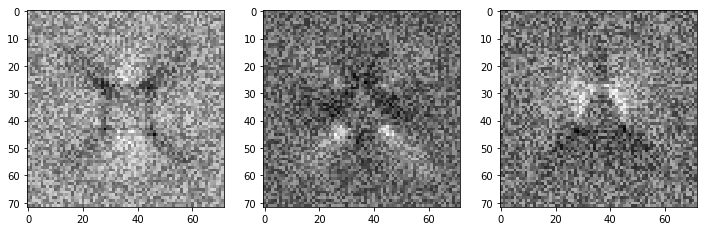

In [12]:
weights = model.get_weights()
fig = plt.figure(figsize=(12, 7))
for i in range(weights[0].shape[1]):
    plt.subplot('13' + str(i+1))
    plt.imshow(weights[0][:, i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

By visualizing the three columns of weights, we can see that the weights correspond to the shape of rectangle, disk and triangle.

## A More Difficult Classification Problem

In this part we change the locations. We firstly regenerate a training dataset with free locations.

In [13]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We use the same Adam optimizer model as before, thus we do not need to redefine the model however just need to compile and fit the model.

In [14]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, np_utils.to_categorical(Y_train, 3), epochs = 20, batch_size = 32)

Epoch 1/20
300/300 [==============================] - 0s 533us/step - loss: 5.5217 - acc: 0.3267
Epoch 2/20
300/300 [==============================] - 0s 130us/step - loss: 3.7384 - acc: 0.3367
Epoch 3/20
300/300 [==============================] - 0s 169us/step - loss: 2.5954 - acc: 0.3533
Epoch 4/20
300/300 [==============================] - 0s 177us/step - loss: 1.9125 - acc: 0.3867
Epoch 5/20
300/300 [==============================] - 0s 121us/step - loss: 1.4639 - acc: 0.4600
Epoch 6/20
300/300 [==============================] - 0s 133us/step - loss: 1.7365 - acc: 0.4133
Epoch 7/20
300/300 [==============================] - 0s 139us/step - loss: 1.3664 - acc: 0.4433
Epoch 8/20
300/300 [==============================] - 0s 121us/step - loss: 1.3318 - acc: 0.4667
Epoch 9/20
300/300 [==============================] - 0s 129us/step - loss: 1.1162 - acc: 0.5133
Epoch 10/20
300/300 [==============================] - 0s 122us/step - loss: 0.9690 - acc: 0.6033
Epoch 11/20
300/300 [========

We can see that the simple linear classifier gets a poor performance for the classification problem of free locations, with an accuracy only around 61% (this accuracy is between 50% and 60% in general).

Now we generate a test dataset to evaluate the model.

In [15]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [16]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 244us/step


[0.9243114248911539, 0.5800000007947286]

We get similar accuracy on test set as on training set.

Now we train a convolutional neural network in order to improve our performance.
We define a CNN with one convolutional layer, one max pooling layer and one fully connected layer.

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, UpSampling2D

model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

X_train = X_train.reshape((X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
model.fit(X_train, np_utils.to_categorical(Y_train, 3), epochs = 20, batch_size = 32)

Epoch 1/20
300/300 [==============================] - 1s 4ms/step - loss: 1.3885 - acc: 0.4067
Epoch 2/20
300/300 [==============================] - 1s 3ms/step - loss: 0.8256 - acc: 0.6800
Epoch 3/20
300/300 [==============================] - 1s 4ms/step - loss: 0.6506 - acc: 0.8133
Epoch 4/20
300/300 [==============================] - 1s 4ms/step - loss: 0.5557 - acc: 0.8067
Epoch 5/20
300/300 [==============================] - 1s 3ms/step - loss: 0.4702 - acc: 0.8533
Epoch 6/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3796 - acc: 0.8767
Epoch 7/20
300/300 [==============================] - 1s 3ms/step - loss: 0.3450 - acc: 0.9167
Epoch 8/20
300/300 [==============================] - 1s 4ms/step - loss: 0.2710 - acc: 0.9433
Epoch 9/20
300/300 [==============================] - 1s 3ms/step - loss: 0.2448 - acc: 0.9433
Epoch 10/20
300/300 [==============================] - 1s 4ms/step - loss: 0.2034 - acc: 0.9733
Epoch 11/20
300/300 [============================

We can see that we get a better performance by using a CNN model, which achieves an accuracy around 99%.

And we evaluate the model on test set.

In [18]:
X_test = X_test.reshape((X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
model.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 2ms/step


[0.9434150266647339, 0.6733333333333333]

The accuracy achieved on test set is around 67% which is not as good as on training set. However it is much better than a simple linear classifier.

## A Regression Problem
Now we want to predict the image locations of the vertices of a triangle. We firstly generate training dataset.

In [19]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


We visualize a sample.

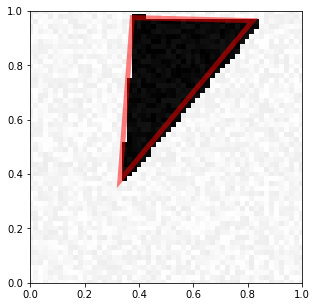

In [20]:
visualize_prediction(X_train[0], Y_train[0])

Before fitting the model, we need to normalize Y_train. Here we sort Y (the vertices' coordinates) for each sample and store indexes of ordered vertices in order to reconstruct the vertices' coordinates.

In [21]:
idxs = np.argsort(Y_train, axis = 1)
Y_sorted = np.sort(Y_train, axis = 1)

Now we define the CNN model for the regression problem and we train the model with 50 epochs and batch size of 32.

We define two convolutional layers with two max pooling layers for feature extraction and two fully connected layer for classifier.

In [22]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6))

model.compile(optimizer=adam,
              loss='mse',
              metrics=['mse'])

X_train = X_train.reshape((X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
model.fit(X_train, Y_sorted, epochs = 50, batch_size = 32)

Epoch 1/50
300/300 [==============================] - 2s 8ms/step - loss: 1.3050 - mean_squared_error: 1.3050
Epoch 2/50
300/300 [==============================] - 2s 5ms/step - loss: 0.2542 - mean_squared_error: 0.2542
Epoch 3/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0704 - mean_squared_error: 0.0704
Epoch 4/50
300/300 [==============================] - 2s 6ms/step - loss: 0.0362 - mean_squared_error: 0.0362
Epoch 5/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0268 - mean_squared_error: 0.0268
Epoch 6/50
300/300 [==============================] - 2s 6ms/step - loss: 0.0233 - mean_squared_error: 0.0233
Epoch 7/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0207 - mean_squared_error: 0.0207
Epoch 8/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0188 - mean_squared_error: 0.0188
Epoch 9/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0163 - mean_squared_error: 0.0163
Epoch 10/5

We now evaluate the performance on training dataset and predict Y on the training set to visualize one sample's prediction against the real one.

In [23]:
model.evaluate(X_train, Y_sorted)

300/300 [==============================] - 1s 2ms/step


[0.0008561545268942912, 0.0008561545268942912]

We see that the Mean Square Error is small. The model maybe not very stable for each training precess and this may be caused by different random initialization. If the final Mean Square Error is not small enough, just retrain the model until it get a satisfactory performance.

In [24]:
Y_pred = model.predict(X_train)
for i in range(Y_pred.shape[0]):
    Y_pred[i, idxs[i]] = Y_pred[i].copy()

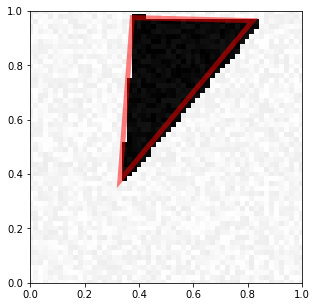

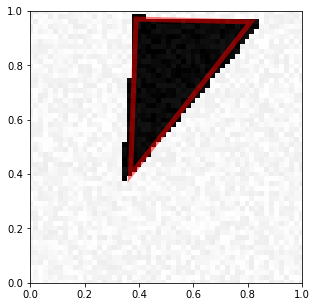

In [25]:
visualize_prediction(X_train[0], Y_train[0])
visualize_prediction(X_train[0], Y_pred[0])

We see that for the shown sample of training set, the model predicts well the three vertices.

Now we generate test set and evaluate the model on test set.

In [26]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [27]:
idxs = np.argsort(Y_test, axis = 1)
Y_test_sorted = np.sort(Y_test, axis = 1)

In [28]:
X_test = X_test.reshape((X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))

In [29]:
Y_pred_test = model.predict(X_test)
for i in range(Y_pred_test.shape[0]):
    Y_pred_test[i, idxs[i]] = Y_pred_test[i].copy()

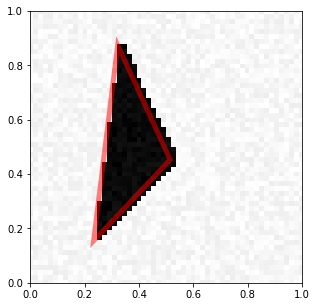

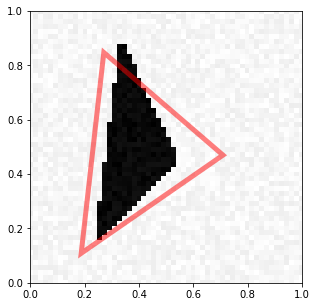

In [30]:
visualize_prediction(X_test[2], Y_test[2])
visualize_prediction(X_test[2], Y_pred_test[2])

For the shown sample of test set, we see that the model does not performe as well as on training set.

In [31]:
model.evaluate(X_test, Y_test_sorted)

300/300 [==============================] - 1s 2ms/step


[0.009611724118391674, 0.009611724118391674]

By evaluating the model on the whole test set, we see that the Mean Square Error is larger than that on the training set. However it is quite small and we can consider that we get a satisfactory performance.

## Image Denoising
In this part, we design a hourglass like network for image denoising.

We first define generate function to generate pairs of images, one with noise and one without.

In [32]:
def generate_pairs_rectangle(noise_amp = 50, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    noise = np.random.rand() * noise_amp
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0), noise

def generate_pairs_disk(noise_amp = 50, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    noise = np.random.rand() * noise_amp
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0), noise

def generate_pairs_triangle(noise_amp = 50, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    noise = np.random.rand() * noise_amp
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0), noise

def generate_image_denoising_dataset(nb_samples, noise_amp = 50, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    noises = np.zeros([nb_samples, 1])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i], noises[i] = generate_pairs_rectangle(noise_amp, free_location)
        elif category == 1: 
            X[i], Y[i], noises[i] = generate_pairs_disk(noise_amp, free_location)
        else:
            X[i], Y[i], noises[i] = generate_pairs_triangle(noise_amp, free_location)
    X = (X + noises) / (255 + 2 * noises)
    Y = Y / 255.0
    return [X, Y]

def generate_image_denoising_test_dataset():
    np.random.seed(42)
    [X_test, Y_test] = generate_image_denoising_dataset(500, 50, True)
    return [X_test, Y_test]

Now we generate the training dataset, with 500 samples and a noise with random amplitude smaller than 50. We allow the free location.

In [33]:
X_train, Y_train = generate_image_denoising_dataset(500, 50, True)

Creating data:
0
100
200
300
400


We visualize a sample of training set with noisy image and noise-free image.

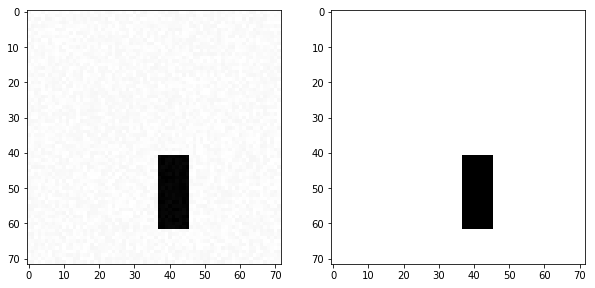

In [35]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(X_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(122)
plt.imshow(Y_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

Now we define a hourglass like CNN with the following structure: 
- convolutional layer (16 channels of kernel 3 x 3, add padding to preserve the image size, ReLU activation)
- max pooling layer (pool_size = 2, stride = 2)
- convolutional layer (32 channels of kernel 3 x 3, add padding to preserve the image size, ReLU activation)
- max pooling layer (pool_size = 2, stride = 2)
- convolutional layer (64 channels of kernel 3 x 3, add padding to preserve the image size, ReLU activation)
- max pooling layer (pool_size = 2, stride = 2)


- up sampling layer (size = 2)
- convolutional layer (32 channels of kernel 3 x 3, add padding to preserve the image size, ReLU activation)
- up sampling layer (size = 2)
- convolutional layer (16 channels of kernel 3 x 3, add padding to preserve the image size, ReLU activation)
- up sampling layer (size = 2)
- convolutional layer (1 channels of kernel 3 x 3, add padding to preserve the image size, ReLU activation)

We take noisy image as input and we try to predict the noise-free image. We train 20 epochs with batch size of 32.

In [36]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                 activation='relu',
                 input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3) , strides=(1, 1), padding='same', 
                 activation='relu'))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3, 3) , strides=(1, 1), padding='same', 
                 activation='relu'))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(1, kernel_size=(3, 3) , strides=(1, 1), padding='same', 
                 activation='relu'))

model.compile(optimizer=adam,
              loss='mse',
              metrics=['mse'])

X_train = X_train.reshape((X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
Y_train = Y_train.reshape((Y_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)

Epoch 1/20
500/500 [==============================] - 8s 15ms/step - loss: 0.7063 - mean_squared_error: 0.7063
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1246 - mean_squared_error: 0.1246
Epoch 3/20
500/500 [==============================] - 8s 15ms/step - loss: 0.0832 - mean_squared_error: 0.0832
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0490 - mean_squared_error: 0.0490
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.0215 - mean_squared_error: 0.0215
Epoch 7/20
500/500 [==============================] - 7s 15ms/step - loss: 0.0156 - mean_squared_error: 0.0156
Epoch 8/20
500/500 [==============================] - 8s 15ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.0103 - mean_squared_error: 0.0103
E

We first visualize a sample of training set and its prediction.

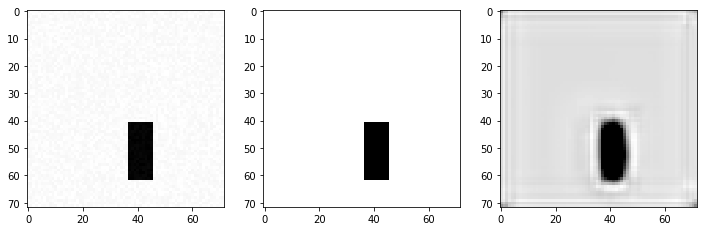

In [38]:
Y_pred = model.predict(X_train)
fig = plt.figure(figsize=(12, 7))
plt.subplot(131)
plt.imshow(X_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(132)
plt.imshow(Y_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(133)
plt.imshow(Y_pred[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

We see that the prediction of noise-free image is smoother than the noisy image. However the edges of the shape are also become smoother.

Now we generate test dataset and evaluate the model on the test set.

In [39]:
X_test, Y_test = generate_image_denoising_test_dataset()

Creating data:
0
100
200
300
400


In [40]:
X_test = X_test.reshape((X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
Y_test = Y_test.reshape((Y_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
model.evaluate(X_test, Y_test)

500/500 [==============================] - 3s 6ms/step


[0.006326245993375778, 0.006326184134930372]

We obtain a similar Mean Square Error on the test set as on the training set.

Now we visualize a sample of test set.

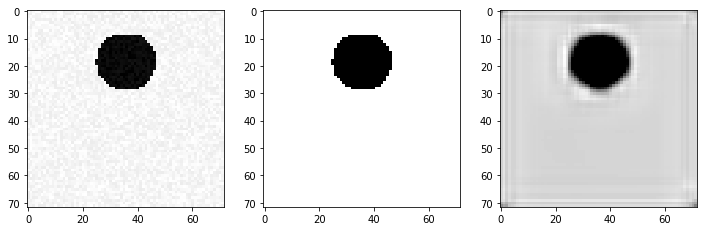

In [42]:
Y_pred_test = model.predict(X_test)
fig = plt.figure(figsize=(12, 7))
plt.subplot(131)
plt.imshow(X_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(132)
plt.imshow(Y_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(133)
plt.imshow(Y_pred_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

We get similar results as on the training set.

Inspired by U-Net structure, we try to modify our network structure to see if we can improve the performance. 

In [43]:
from keras.layers.merge import concatenate

def UNet_denoising(input_img, n_filters = 16, kernel_size = 3):
    conv1 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), strides=(1, 1), 
               padding='same', activation='relu')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv1)
    conv2 = Conv2D(filters=n_filters * 2, kernel_size=(kernel_size, kernel_size), strides=(1, 1), 
               padding='same', activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    conv3 = Conv2D(filters=n_filters * 4, kernel_size=(kernel_size, kernel_size), strides=(1, 1), 
               padding='same', activation='relu')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv3)
    
    up4 = UpSampling2D(size=(2, 2))(pool3)
    up_conv4 = Conv2D(filters=n_filters * 2, kernel_size=(kernel_size, kernel_size), strides=(1, 1), 
               padding='same', activation='relu')(up4)
    up5 = UpSampling2D(size=(2, 2))(up_conv4)
    up_conv5 = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), strides=(1, 1), 
               padding='same', activation='relu')(up5)
    merge5 = concatenate([conv2, up_conv5])
    up6 = UpSampling2D(size=(2, 2))(merge5)
    up_conv6 = Conv2D(filters=1, kernel_size=(kernel_size, kernel_size), strides=(1, 1), 
               padding='same', activation='relu')(up6)
    merge6 = concatenate([conv1, up_conv6])
    outputs = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), 
               padding='same', activation='relu')(merge6)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [46]:
from keras.layers import Input
from keras.models import Model

input_img = Input((IMAGE_SIZE, IMAGE_SIZE, 1), name='img')
model = UNet_denoising(input_img)

model.compile(optimizer=adam,
              loss='mse',
              metrics=['mse'])

model.fit(X_train, Y_train, epochs = 30, batch_size = 32)

Epoch 1/30
500/500 [==============================] - 13s 25ms/step - loss: 0.3195 - mean_squared_error: 0.3195
Epoch 2/30
500/500 [==============================] - 12s 23ms/step - loss: 0.0489 - mean_squared_error: 0.0489
Epoch 3/30
500/500 [==============================] - 16s 33ms/step - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 4/30
500/500 [==============================] - 14s 28ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 5/30
500/500 [==============================] - 12s 24ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 6/30
500/500 [==============================] - 12s 24ms/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 7/30
500/500 [==============================] - 12s 25ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 8/30
500/500 [==============================] - 12s 24ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 9/30
500/500 [==============================] - 12s 24ms/step - loss: 0.0046 - mean_squared_error:

Here we choose to train 30 epochs. However we can see that at 20th epoch (the same number of epochs as before), we already get a smaller Mean Square Error than the previous simple model. So the U-Net structure can really improve the performance.

Now we visualize the same sample as before to see the result.

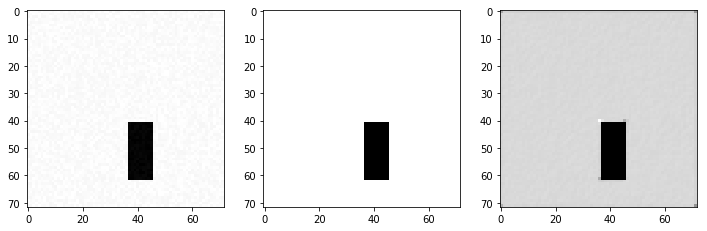

In [47]:
Y_pred = model.predict(X_train)
fig = plt.figure(figsize=(12, 7))
plt.subplot(131)
plt.imshow(X_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(132)
plt.imshow(Y_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(133)
plt.imshow(Y_pred[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

We can see that the prediction of U-Net is smoother than the noisy image and it preserves the edges of the shape.

Now we evaluate the model on test set.

In [48]:
model.evaluate(X_test, Y_test)

500/500 [==============================] - 5s 10ms/step


[0.000726804459001869, 0.0007268023751676083]

We get a much smaller Mean Square Error on test set by U-Net than the previous simple model.

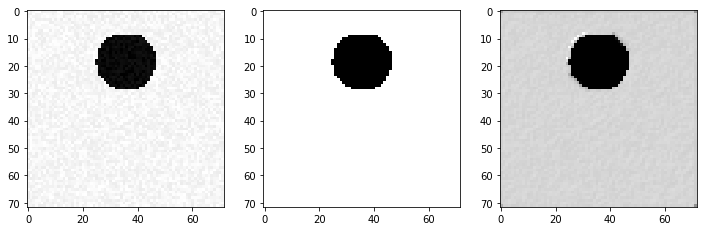

In [49]:
Y_pred_test = model.predict(X_test)
fig = plt.figure(figsize=(12, 7))
plt.subplot(131)
plt.imshow(X_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(132)
plt.imshow(Y_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.subplot(133)
plt.imshow(Y_pred_test[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

On the test set, U-Net model can also obtain a smoother image and preserve the edges.

## Conclusion
In this notebook, we accomplished the tasks of Simple Classification (disk, rectangle and triangle), Difficult Classification with Free Location, Regression of Triangle's vertices and Image Denoising by designing different neural network structures. There are some points to note: 

- Adam optimizer usually have a better performance than SGD.

- While designing the neural network structure, we had better begin with simple structure. If the simple structure does not produce satisfactory performance, we try deeper networks or even more complex structure, such as CNN.

- In the difficult classification problem with free locations, clearly it is more difficult to get a good performance as in the simple case, thus we design a CNN which obtains a good performance on training set. However the accuracy on test set is still not high enough.

- In the Regression task, we made a trick to obtain satisfactory performance, which is to order the vertices' coordinates for training and testing and to reconstruct the real coordinates afterwards. The results show that this trick can really improve the performance.

- In the Image Denoising task, we implement U-Net like structure which is shown to be useful to improve the performance of image denoising task.